In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import sklearn.metrics as metrics
import torch
from ray import air, tune
from ray.air import session

import flippers
from flippers.models import SnorkelModel

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
# This helper loads any dataset in the wrench benchmarks
# and creates monopolar label matrices from their multipolar data
def load_wrench_dataset(dataset):
    dataset = "datasets/" + f"{dataset}" + "/{}.json"
    train = pd.read_json(dataset.format("train")).T
    dev = pd.read_json(dataset.format("valid")).T
    test = pd.read_json(dataset.format("test")).T

    L_train, polarities, polarities_mapping = flippers.multipolar_to_monopolar(
        train["weak_labels"].apply(pd.Series)
    )
    L_dev, _, _ = flippers.multipolar_to_monopolar(
        dev["weak_labels"].apply(pd.Series), polarities_mapping
    )
    L_test, _, _ = flippers.multipolar_to_monopolar(
        test["weak_labels"].apply(pd.Series), polarities_mapping
    )

    return (train, dev, test), (L_train, L_dev, L_test), polarities

In [6]:
def score(model, L, y_true, boxplots=True, fill_proba=False, name=""):
    y_pred = model.predict_proba(L)[:, 1]

    def fill_proba(proba):
        proba = proba.copy()
        proba[L.sum(axis=1) == 0] = class_balances[1]
        return proba

    if fill_proba:
        y_pred = fill_proba(y_pred)

    AP = metrics.average_precision_score(y_true, y_pred)
    F1 = metrics.f1_score(y_true, y_pred.round())
    AUC = metrics.roc_auc_score(y_true, y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred.round())
    Balanced_Accuracy = metrics.balanced_accuracy_score(y_true, y_pred.round())
    M = {
        "F1": F1,
        "Average_Precision": AP,
        "AUC": AUC,
        "Accuracy": Accuracy,
        "Balanced_Accuracy": Balanced_Accuracy,
    }
    for key in M:
        M[key] = round(M[key], 3)

    if boxplots:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        pd.DataFrame({"y_pred": y_pred, "y_true": y_true}).boxplot(
            by="y_true", ax=axs[0]
        )
        axs[0].set_title("Predicted probabilities grouped by ground truth")
        axs[0].set_ylim([0, 1])
        axs[0].get_figure().suptitle("")
        plt.ylabel("y_pred")

        pd.Series(y_pred).plot.box(ax=axs[1])
        axs[1].set_title("Predicted probabilties")
        axs[1].set_ylim([0, 1])
        axs[1].axhline(
            y_true.mean(), color="g", linestyle="--", alpha=0.3, label="Mean of y_true"
        )

        # Add a cross indicating the mean of y_pred
        mean_y_pred = pd.Series(y_pred).mean()
        axs[1].scatter(
            [1], [mean_y_pred], marker="+", color="r", s=200, label="Mean of y_pred"
        )
        axs[1].legend()

        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()
    if name:
        global Metrics
        Metrics[name] = M
    return M

In [7]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
Best_Configs = {}
Results = {}
Metrics = {}

In [8]:
dataset_to_metric = {
    "imdb": "Accuracy",
    "yelp": "Accuracy",
    "youtube": "Accuracy",
    "sms": "F1",
    "agnews": "Accuracy",
    "trec": "Accuracy",
    "spouse": "F1",
    "cdr": "F1",
    "semeval": "Accuracy",
    "chemprot": "Accuracy",
    "commercial": "F1",
    "tennis": "F1",
    "basketball": "F1",
    "census": "F1",
}

In [9]:
%%time

# Define a search space and initialize the search algorithm.
search_space = {
    "learning_rate": tune.grid_search([1e-2, 5e-3, 1e-3]),
    "num_epochs": tune.grid_search([50, 100, 200]),
    "k": tune.grid_search([0, 1e-1, 5e-2, 1e-2, 5e-3, 1e-4]),
}

for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels
    del train

    y_dev = dev["label"].values.astype(int)
    y_test = test["label"].values.astype(int)

    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )

    # Wrap SnorkelModel in an objective function
    def objective(config):
        m = SnorkelModel(polarities=polarities, class_balances=class_balances)
        m.fit(L_train, **config, device="cuda")
        scores = score(m, L_dev, y_dev, boxplots=False)  # Compute validation metrics
        session.report(scores)  # Report to Tune

    # Start a Tune run that maximizes metric on dev set
    tuner = tune.Tuner(
        tune.with_resources(objective, {"cpu": 8, "gpu": 0.5}),
        param_space=search_space,
        run_config=air.RunConfig(progress_reporter=tune.JupyterNotebookReporter()),
    )
    results = tuner.fit()

    metric = dataset_to_metric[dataset]
    best_result = results.get_best_result(metric=metric, mode="max")
    Best_Configs[dataset] = best_result.config
    Results[dataset] = results

    m = SnorkelModel(polarities=polarities, class_balances=class_balances)
    config = best_result.config
    m.fit(L_train, **config)

    Metrics[dataset] = score(m, L_test, y_test, boxplots=False)

Trial name,AUC,Accuracy,Average_Precision,Balanced_Accuracy,F1,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_b43f8_00000,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-27,True,,7ab1348229554207b6859e2ff8a856f2,"0_k=0,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,19004,0.455771,0.455771,0.455771,1680587907,0,,1,b43f8_00000,0.01561
objective_b43f8_00001,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-33,True,,e358ab894b944d7aa19709b8843b2277,"1_k=0.1000,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,37304,0.517925,0.517925,0.517925,1680587913,0,,1,b43f8_00001,0
objective_b43f8_00002,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-33,True,,7ab1348229554207b6859e2ff8a856f2,"2_k=0.0500,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,19004,0.282615,0.282615,0.282615,1680587913,0,,1,b43f8_00002,0.01561
objective_b43f8_00003,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-33,True,,7ab1348229554207b6859e2ff8a856f2,"3_k=0.0100,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,19004,0.266994,0.266994,0.266994,1680587913,0,,1,b43f8_00003,0.01561
objective_b43f8_00004,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-33,True,,e358ab894b944d7aa19709b8843b2277,"4_k=0.0050,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,37304,0.231666,0.231666,0.231666,1680587913,0,,1,b43f8_00004,0
objective_b43f8_00005,0.89,0.891,0.849,0.883,0.864,2023-04-03_22-58-34,True,,7ab1348229554207b6859e2ff8a856f2,"5_k=0.0001,learning_rate=0.0100,num_epochs=50",LAPTOP,1,127.0.0.1,19004,0.234741,0.234741,0.234741,1680587914,0,,1,b43f8_00005,0.01561
objective_b43f8_00006,0.893,0.891,0.863,0.883,0.864,2023-04-03_22-58-34,True,,e358ab894b944d7aa19709b8843b2277,"6_k=0,learning_rate=0.0050,num_epochs=50",LAPTOP,1,127.0.0.1,37304,0.125467,0.125467,0.125467,1680587914,0,,1,b43f8_00006,0
objective_b43f8_00007,0.893,0.891,0.863,0.883,0.864,2023-04-03_22-58-34,True,,7ab1348229554207b6859e2ff8a856f2,"7_k=0.1000,learning_rate=0.0050,num_epochs=50",LAPTOP,1,127.0.0.1,19004,0.264529,0.264529,0.264529,1680587914,0,,1,b43f8_00007,0.01561
objective_b43f8_00008,0.893,0.891,0.863,0.883,0.864,2023-04-03_22-58-34,True,,e358ab894b944d7aa19709b8843b2277,"8_k=0.0500,learning_rate=0.0050,num_epochs=50",LAPTOP,1,127.0.0.1,37304,0.233277,0.233277,0.233277,1680587914,0,,1,b43f8_00008,0
objective_b43f8_00009,0.893,0.891,0.863,0.883,0.864,2023-04-03_22-58-34,True,,e358ab894b944d7aa19709b8843b2277,"9_k=0.0100,learning_rate=0.0050,num_epochs=50",LAPTOP,1,127.0.0.1,37304,0.204047,0.204047,0.204047,1680587914,0,,1,b43f8_00009,0


2023-04-03 22:58:48,001	INFO tune.py:798 -- Total run time: 26.66 seconds (26.58 seconds for the tuning loop).


CPU times: total: 48.5 s
Wall time: 4min 43s


In [10]:
df = pd.DataFrame(Metrics)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries)

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
F1,0.712000,0.745000,0.823000,0.608000,0.503000,0.138000,0.071000,0.822000
Average_Precision,0.655000,0.799000,0.930000,0.660000,0.342000,0.118000,0.140000,0.793000
AUC,0.842000,0.799000,0.925000,0.859000,0.716000,0.529000,0.521000,0.885000
Accuracy,0.782000,0.680000,0.852000,0.808000,0.911000,0.857000,0.844000,0.873000
Balanced_Accuracy,0.796000,0.670000,0.845000,0.746000,0.751000,0.527000,0.506000,0.873000


In [11]:
pd.DataFrame(Best_Configs)

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
learning_rate,0.001,0.010,0.001,0.005,0.01,0.01,0.01,0.01
num_epochs,50.000,50.000,50.000,50.000,50.00,100.00,50.00,50.00
k,0.000,0.005,0.100,0.050,0.00,0.05,0.00,0.00


# Inspect best hyperparameter value per model

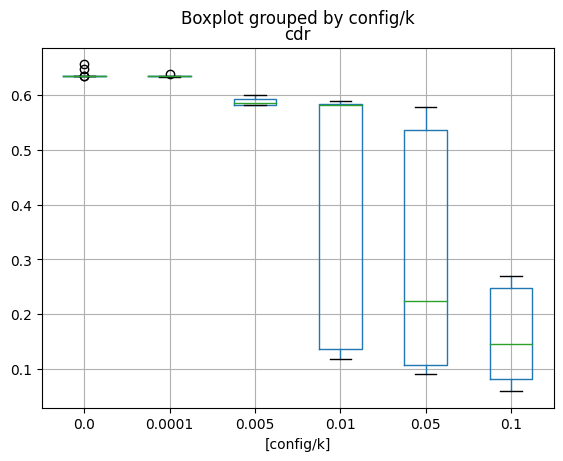

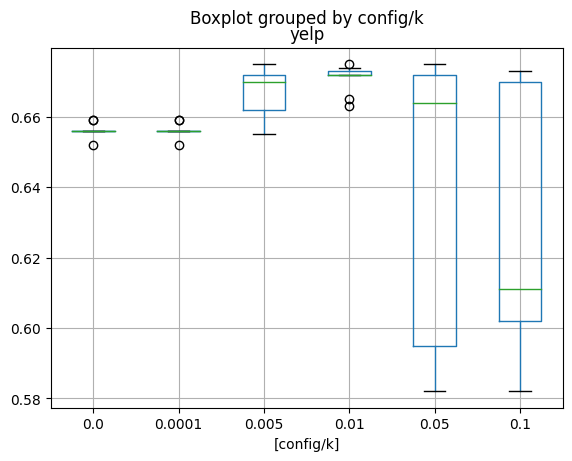

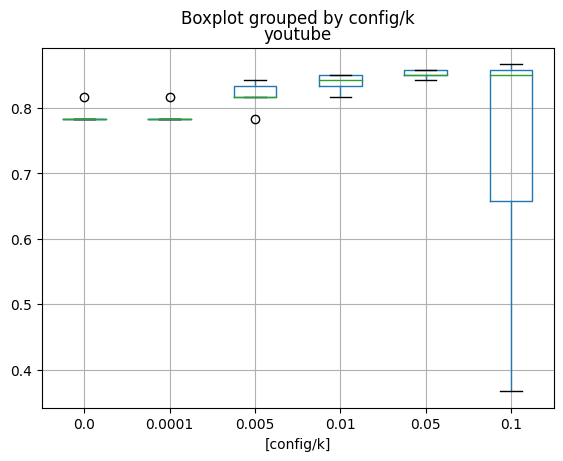

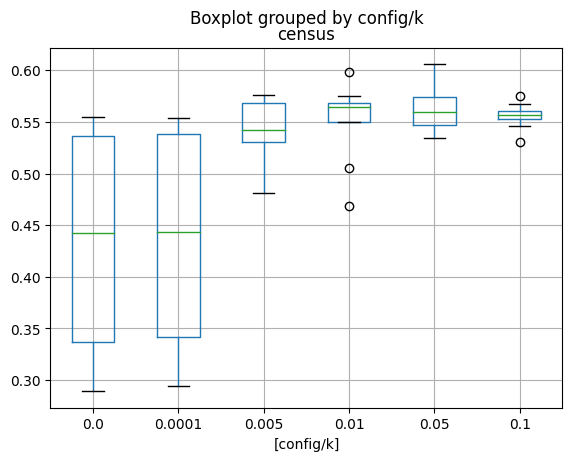

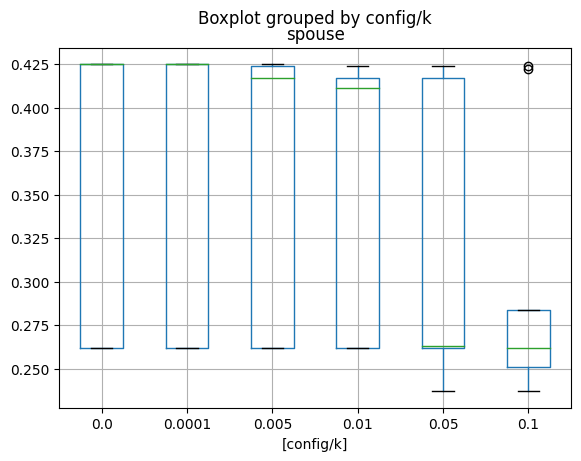

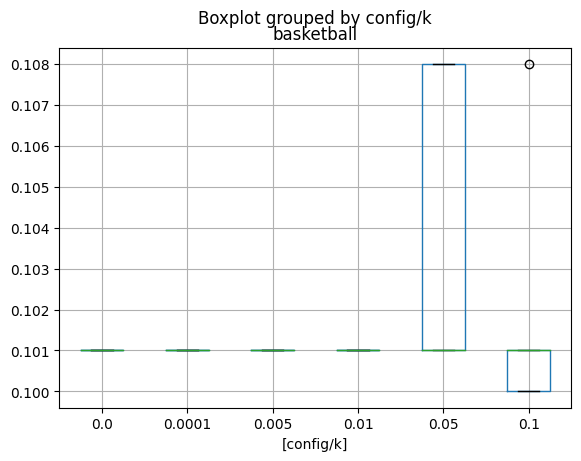

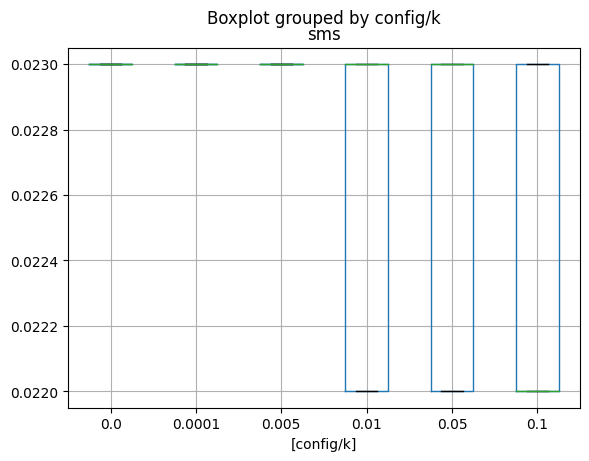

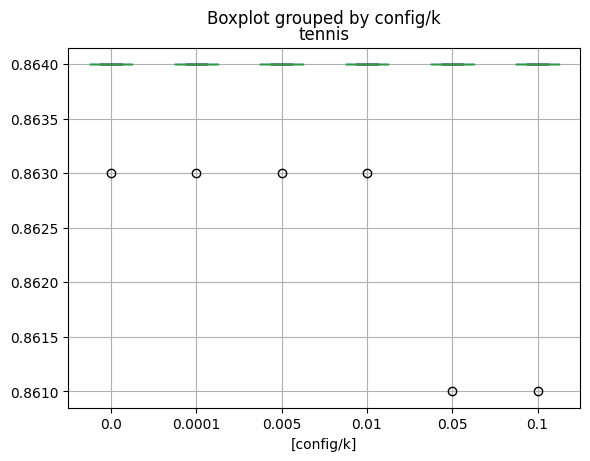

In [31]:
for dataset in datasets:
    grid = Results[dataset]
    hparam = "k"
    hparam = "config/" + hparam
    grid.get_dataframe()[[dataset_to_metric[dataset], hparam]].boxplot(by=hparam)
    plt.title(dataset)